In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso # Linear Regression with regularization
from sklearn.linear_model import Ridge # regularised linear regression
from sklearn.metrics import mean_squared_error

import pickle

In [2]:
# !pip install pyarrow

In [3]:
df_train = pd.read_parquet('../data/fhv_tripdata_2021-01.parquet')
df_val = pd.read_parquet('../data/fhv_tripdata_2021-02.parquet')

In [4]:
df_train

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037
...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


In [6]:
df_train['duration'] = df_train.dropOff_datetime - df_train.pickup_datetime
df_train.duration = df_train.duration.apply(lambda td: td.total_seconds() / 60)

df_val['duration'] = df_val.dropOff_datetime - df_val.pickup_datetime
df_val.duration = df_val.duration.apply(lambda td: td.total_seconds() / 60)

In [7]:
df_train.duration.mean()

19.1672240937939

C:\Users\Bhaskar\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

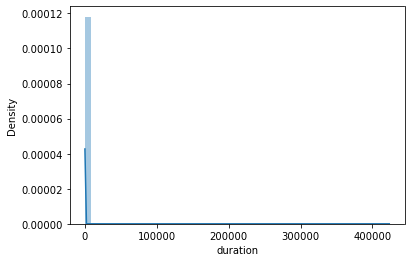

In [8]:
sns.distplot(df_train.duration)

In [9]:
len(df_train)

1154112

In [10]:
df_train = df_train[(df_train.duration >= 1) & (df_train.duration <= 60) ]
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60) ]

In [11]:
len(df_train)

1109826

No of dropped records with outliers: 1,154,112 - 1,109,826 = 44,286

<AxesSubplot:>

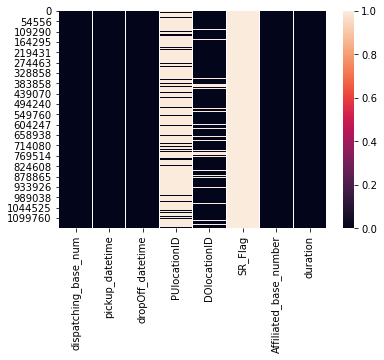

In [12]:
sns.heatmap(df_train.isna())

In [13]:
df_train['PUlocationID'] =  df_train.PUlocationID.replace(to_replace = np.nan, value = -1)
df_train['DOlocationID'] =  df_train.DOlocationID.replace(to_replace = np.nan, value = -1)

df_val['PUlocationID'] =  df_val.PUlocationID.replace(to_replace = np.nan, value = -1)
df_val['DOlocationID'] =  df_val.DOlocationID.replace(to_replace = np.nan, value = -1)

<ipython-input-13-d142e0ccaea3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['PUlocationID'] =  df_train.PUlocationID.replace(to_replace = np.nan, value = -1)
<ipython-input-13-d142e0ccaea3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['DOlocationID'] =  df_train.DOlocationID.replace(to_replace = np.nan, value = -1)


In [14]:
# nan_recs = df_train2.PUlocationID.isna().sum()
nan_recs = len(df_train[df_train.PUlocationID == -1])
print((nan_recs/len(df_train))*100)

83.52732770722618


In [15]:
categorical = ['PUlocationID','DOlocationID']
df_train[categorical] = df_train[categorical].astype(str)
df_val[categorical] = df_val[categorical].astype(str)

C:\Users\Bhaskar\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [16]:
dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
X_train.shape, X_val.shape

((1109826, 525), (990113, 525))

In [18]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [19]:
def train_model(lr = LinearRegression()):
    # For Rapid and clean experimentaion
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_train)
    print('train mse',mean_squared_error(y_train, y_pred, squared=False))
    
    y_pred = lr.predict(X_val)
    print('val mse',mean_squared_error(y_val, y_pred, squared=False))

In [20]:
train_model()

train mse 10.528519107204405
val mse 11.014283137481941
